In [6]:
import random
import time
import os
import glob 
import networkx as nx
import numpy as np
from copy import deepcopy
from tabulate import tabulate
from matplotlib import pyplot as plt

RESULTS_PATH = "resultsGA"

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

# Omogućava prikaz grafikona unutar Notebook-a
%matplotlib inline

In [7]:
def maxNumOfColours(graph):
    maxDegree = 0
    for i in graph:
        degree = len(list(graph.neighbors(i)))
        if degree > maxDegree:
            maxDegree = degree
    return maxDegree
 

def readGraph(filePath):
    graph = nx.Graph()
    edges = []
    
    with open(filePath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts: continue
            
            # Preskoči meta-podatke (p edge 11 55)
            if parts[0] in ['p', 'c', 'edge']:
                continue
            
            # Čitaj ivice
            try:
                if len(parts) >= 2:
                    # Uzimamo prva dva broja u redu, šta god da su
                    u, v = int(parts[-2]), int(parts[-1])
                    edges.append((u, v))
            except ValueError:
                continue

    # Ključni momenat: NetworkX automatski kreira čvorove na osnovu ivica
    graph.add_edges_from(edges)
    
    # Ispisujemo tačan broj učitanih ivica radi tvoje provere
    # Ako ovde ne piše 55 za K11, fajl ti ne valja!
    return graph

def getFitness(chromosome, edges, maxNode):
    # node_slots: za svaki čvor čuvamo listu boja njegovih ivica
    node_slots = [[] for _ in range(maxNode + 1)]
    
    for i, (u, v) in enumerate(edges):
        color = chromosome[i]
        node_slots[u].append(color)
        node_slots[v].append(color)

    total_conflicts = 0
    for colors in node_slots:
        if len(colors) < 2:
            continue
            
        colors.sort()
        
        current_count = 1
        for j in range(1, len(colors)):
            if colors[j] == colors[j-1]:
                current_count += 1
            else:
                if current_count > 1:
                    total_conflicts += (current_count * (current_count - 1)) // 2
                current_count = 1
        if current_count > 1:
            total_conflicts += (current_count * (current_count - 1)) // 2
            
    return total_conflicts

In [8]:
def selectionTournament(population, fitnesses, k=3):
    participants = random.sample(list(zip(population, fitnesses)), k)
    return min(participants, key=lambda x: x[1])[0]

def selectionRoulette(population, fitnesses):
    # Što manji fitnes, to veća šansa (proporcionalno 1/f)
    invertedFitness = [1.0 / (f + 1e-6) for f in fitnesses]
    total = sum(invertedFitness)
    pick = random.uniform(0, total)
    current = 0
    for i, f in enumerate(invertedFitness):
        current += f
        if current > pick:
            return population[i]
    return population[0]

def selectionRank(population, fitnesses):
    popSize = len(population)
    sortedIndices = np.argsort(fitnesses)
    ranks = np.empty(popSize)
    for rank, idx in enumerate(range(popSize)):
        ranks[sortedIndices[idx]] = popSize - rank
    totalRank = sum(ranks)
    pick = random.uniform(0, totalRank)
    current = 0
    for i in range(popSize):
        current += ranks[i]
        if current > pick: return population[i]
    return population[0]


In [9]:
def crossoverUniform(p1, p2):
    return [p1[i] if random.random() < 0.5 else p2[i] for i in range(len(p1))]

def crossoverSinglePoint(p1, p2):
    point = random.randint(1, len(p1) - 1)
    return p1[:point] + p2[point:]

def crossoverTwoPoint(p1, p2):
    size = len(p1)
    if size < 3: return crossoverSinglePoint(p1, p2)
    pt1 = random.randint(1, size - 2)
    pt2 = random.randint(pt1 + 1, size - 1)
    return p1[:pt1] + p2[pt1:pt2] + p1[pt2:]


In [10]:
def mutationSmart(chromosome, edges, maxNode, numColors):
    idx = random.randrange(len(chromosome))
    u, v = edges[idx]
    forbidden = set()
    
    # Prolazimo kroz sve ivice da nađemo susedne (optimizaćemo ovo kasnije)
    for i, (n1, n2) in enumerate(edges):
        if i != idx and (n1 in (u, v) or n2 in (u, v)):
            forbidden.add(chromosome[i])
            
    # Koristimo isključivo DOZVOLJENI opseg boja (numColors)
    available = list(set(range(1, numColors + 1)) - forbidden)
    
    if available:
        chromosome[idx] = random.choice(available)
    else:
        # Ako nema slobodne boje u dozvoljenom opsegu, 
        # uzmi bilo koju iz DOZVOLJENOG opsega, ne dodaj nove!
        chromosome[idx] = random.randint(1, numColors) 
    return chromosome


def mutationRandom(chromosome, edges, maxNode,numColors):
    idx = random.randrange(len(chromosome))
    chromosome[idx] = random.randint(1, numColors)
    return chromosome

#def mutationSwap(chromosome, edges, maxNode, delta):
#    idx1, idx2 = random.sample(range(len(chromosome)), 2)
#    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
#    return chromosome
#KAO NIJE KORISNO ZA MINIMUM EDGE COLORING


def mutationConflict(chromosome, edges, maxNode, numColors):
    # 1. Mapiramo koji čvor ima koje boje na svojim ivicama
    # Ovo nam pomaže da brzo vidimo gde su duplikati boja
    node_colors = {i: [] for i in range(1, maxNode + 1)}
    for i, (u, v) in enumerate(edges):
        node_colors[u].append(chromosome[i])
        node_colors[v].append(chromosome[i])
        
    # 2. Pronalazimo indekse svih ivica koje učestvuju u konfliktu
    conflicted_indices = []
    for i, (u, v) in enumerate(edges):
        # Ako se trenutna boja ivice pojavljuje više od jednom kod čvora u ili v
        if node_colors[u].count(chromosome[i]) > 1 or node_colors[v].count(chromosome[i]) > 1:
            conflicted_indices.append(i)
            
    # 3. Akcija:
    if not conflicted_indices:
        # Ako nema konflikata (čestitamo!), uradi malu nasumičnu promenu
        idx = random.randrange(len(chromosome))
        chromosome[idx] = random.randint(1, numColors)
    else:
        # Izaberi jednu od ivica koje STVARNO prave problem i promeni joj boju
        idx = random.choice(conflicted_indices)
        chromosome[idx] = random.randint(1, numColors)
    
    return chromosome



In [11]:
def normEdge(u, v):
    return (u, v) if u < v else (v, u)

In [12]:
def confIndices(solution, edges, edgesIndex, neighbourhood):
    conflictingIndices = []
    for i, edge in enumerate(edges):
        # Proveravamo komšije preko unapred spremljene liste
        for nei_edge in neighbourhood[edge]:
            idx = edgesIndex[nei_edge]
            if solution[idx] == solution[i]:
                conflictingIndices.append(i)
                break 
    return conflictingIndices

In [13]:
def getNeighbours(graph, edges):
    neighbourhood = {normEdge(u, v): [] for _, (u, v) in enumerate(graph.edges())} 


    for edge in edges:
        u, v = edge
        uNei = list(graph.neighbors(u))
        vNei = list(graph.neighbors(v))
        uNei.remove(v)
        vNei.remove(u)
        mapa = {}

        for i in    uNei:
            nei = normEdge(u, i)
            neighbourhood[edge].append(nei)
            mapa[nei] = True

        for i in vNei:
            nei = normEdge(v, i)
            if nei not in mapa:
              neighbourhood[edge].append(nei)

    return neighbourhood

In [14]:
def recalcConflicts(edges, edgesIndex, oldConf, solution, neighbourhood, oldColour, newColour, i):
    num = 0

    edge = edges[i]
    myNeighbours = neighbourhood[edge]

    for nei in myNeighbours:
        idx = edgesIndex[nei]
        if solution[idx] == oldColour:
            num -= 1
        if solution[idx] == newColour:
            num += 1
    
    return oldConf + num


In [15]:
def localSearchRepair(code, edges, neighbourhood, maxColor, maxSteps, edgesIndex,maxNode):
    for _ in range(maxSteps):

        #fitness = getFitness(code, edges, 0)
        #max_n = max(max(u, v) for u, v in edges)
        fitness = getFitness(code, edges, maxNode)#trenutni fitnes

        if fitness == 0:
            break

        # confEdges = []
        # for i in range(len(code)):
        #     for nei in neighbourhood[i]:
        #         if code[i] == code[nei]:
        #             confEdges.append(i)
        #             break
        confEdges = confIndices(code, edges, edgesIndex, neighbourhood)
        
        if not confEdges:
            break
            # return code

        # e = random.choice(confEdges)#indeks ivice
        # oldColor = code[e]


        # for color in range(1,maxColor+1):
        #     if color == oldColor:
        #         continue

        #     code[e] = color
        #     newFitness = recalcConflicts(edges, edgesIndex, fitness, code, neighbourhood, oldColor, color, e)

        #     if newFitness < fitness:
        #         fitness = newFitness
        #         break
        #         # return code
        #     else:
        #         code[e] = oldColor
        edgeIdx = random.choice(confEdges)
        u, v = edges[edgeIdx]
        
        # Skupljamo boje susednih ivica da nađemo slobodnu
        forbidden = set()
        for nei_edge in neighbourhood[edges[edgeIdx]]:
            forbidden.add(code[edgesIndex[nei_edge]])
            
        available = [c for c in range(1, maxColor + 1) if c not in forbidden]
        if available:
            code[edgeIdx] = random.choice(available)
        else:
            code[edgeIdx] = random.randint(1, maxColor)

    return code

In [16]:
def calcConflicts(edges, edgesIndex, solution, neighbourhood):
    num  = 0
    
    for i in range(len(edges)):
        edge = edges[i]
        myNeighbours = neighbourhood[edge]

        for nei in myNeighbours:
            idx = edgesIndex[nei]
            if solution[idx] == solution[i]:
                num += 1
        
    return (num // 2)

In [37]:
def runGaModular(graph, maxIters, popSize, selFunc, crossFunc, mutFunc, numColours):
    #edges = list(graph.edges())
    edges = [normEdge(u, v) for (u,v) in graph.edges()]
    if not edges: return [], 0, []
    edgesIndex = {edge : i for i, edge in enumerate(edges)}
    neighbourhood = getNeighbours(graph, edges)
    
    # maxNode nam treba za mutationConflict da zna veličinu rečnika čvorova
    maxNode = max(graph.nodes())
    numEdges = len(edges)
    
    # Inicijalizacija: Sada strogo poštujemo numColours
    population = [[random.randint(1, numColours) for _ in range(numEdges)] for _ in range(popSize)]
    
    history = []
    
    for gen in range(maxIters):
        fitnesses = [getFitness(c, edges, maxNode) for c in population]
        # fitnesses = [calcConflicts(edges, edgesIndex, c, neighbourhood) for c in population]
        bestFit = min(fitnesses)
        #print(gen,bestFit,flush=True)#ispisuje gen i fitnes
        history.append(bestFit)
        
        if bestFit == 0:
            # Popunjavamo istoriju do kraja radi grafikona
            history.extend([0] * (maxIters - len(history)))
            break
            
        # Elitizam: Sortiramo i uzimamo 2 najbolja
        popWithFit = sorted(zip(population, fitnesses), key=lambda x: x[1])
        newPop = [popWithFit[0][0], popWithFit[1][0]]
        
        while len(newPop) < popSize:
            # 1. Poboljšanje: Izbegavamo da p1 i p2 budu ista jedinka (ako je moguće)
            p1_idx = population.index(selFunc(population, fitnesses))
            p2_idx = population.index(selFunc(population, fitnesses))
            
            # Ako je populacija raznolika, probaj da nađeš različite roditelje
            attempts = 0
            while p1_idx == p2_idx and attempts < 5:
                p2_idx = population.index(selFunc(population, fitnesses))
                attempts += 1
            
            p1, p2 = population[p1_idx], population[p2_idx]
            
            #2. Ukrštanje
            child = crossFunc(p1, p2)
            
            # 3. Mutacija (povećana šansa jer koristimo pametne mutacije)
            # Za Edge Coloring, 0.3 - 0.4 je odličan ratio
            if random.random() < 0.1:
                # mutationConflict i mutationSmart sada dobijaju sve što im treba
                child = mutFunc(child, edges, maxNode, numColours)
                
            if gen >= 2500:
                child = localSearchRepair(child, edges, neighbourhood, numColours, 30, edgesIndex,maxNode)

            newPop.append(child)
            # 1. Ukrštanje - dobijamo dvoje dece
            # child1, child2 = crossFunc(p1, p2)

            # for c in [child1, child2]:
            #     if len(newPop) < popSize:
            #  # 2. Mutacija - samo u 35% slučajeva (da ne kvarimo previše)
            #         if random.random() < 0.35:
            #             c = mutFunc(c, edges, maxNode, numColours)
        
            # # 3. Local Search - uvek popravlja dete ako smo u kasnijoj fazi
            #         if gen >= 600:
            #             c = localSearchRepair(c, edges, neighbourhood, numColours, 10, edgesIndex, maxNode)
        
            #         newPop.append(c)

            
        population = deepcopy(newPop)
        
    # Finalna provera najboljeg
    finalFits = [getFitness(c, edges, maxNode) for c in population]
    bestIdx = np.argmin(finalFits)
    
    return population[bestIdx], finalFits[bestIdx], history

In [38]:
def processAndVisualize(filePath):
    graph = readGraph(filePath)

    # >>> OVDE DODAJ OVE LINIJE <<<
    print(f"\n" + "="*40)
    print(f"DEBUG ZA FAJL: {os.path.basename(filePath)}")
    print(f"Stvarni broj čvorova: {graph.number_of_nodes()}")
    print(f"Stvarni broj ivica: {graph.number_of_edges()}")
    # >>> KRAJ DODATKA <<<

    fileName = os.path.basename(filePath)
    delta = maxNumOfColours(graph)

    # Dodaj i ovo da proverimo šta je funkcija izračunala za Deltu
    print(f"Izračunata Delta: {delta}")
    print("="*40 + "\n")

    if graph.number_of_edges() == 0: return

    
    f_lower = fileName.lower()
    type_info = "Unknown Graph Type"
    theory_note = ""
    is_bipartite = nx.is_bipartite(graph)
    if "completegraph" in f_lower or "k_" in f_lower:
        try:
            n = int(''.join(filter(str.isdigit, fileName)))
            type_info = f"Complete Graph K({n})"
            if n % 2 == 0: theory_note = f"Class 1 (Expected χ' = Δ = {n-1})"
            else: theory_note = f"Class 2 (Expected χ' = Δ + 1 = {n})"
        except: type_info = "Complete Graph"
    elif "bipartite" in f_lower or is_bipartite:
        type_info = "Bipartite Graph"
        theory_note = f"Always Class 1 (Expected χ' = Δ = {delta})"
    elif "petersen" in f_lower or "snark" in f_lower or "flower" in f_lower:
        type_info = "SNARK / Petersen Graph"
        theory_note = f"Class 2 (Expected χ' = Δ + 1 = {delta+1})"
    elif "regular" in f_lower:
        type_info = f"Random Regular Graph (d={delta})"
        theory_note = "Most are Class 1"
    elif "graph" in f_lower:
        type_info = "Random G(n,p) Graph"
        theory_note = "Vizing's Theorem: Class 1 or 2"

    print(f"\n>>> ANALYZING: {fileName}")
    print(f"[TYPE]: {type_info}")
    if theory_note: print(f"[THEORY]: {theory_note}")

    selections = [selectionTournament, selectionRoulette, selectionRank]
    crossovers = [crossoverUniform, crossoverSinglePoint, crossoverTwoPoint]
    mutations = [mutationSmart, mutationRandom, mutationConflict]

    
    def run_tests(num_cols):
        res_list = []
        for sel in selections:
            for cross in crossovers:
                for mut in mutations:
                    sName = sel.__name__.replace('selection', '')
                    cName = cross.__name__.replace('crossover', '')
                    mName = mut.__name__.replace('mutation', '')
                    t0 = time.perf_counter()
                    sol, fit, hist = runGaModular(graph, 3000, 200, sel, cross, mut, num_cols)
                    dt = time.perf_counter() - t0
                    res_list.append({'selection': sName, 'crossover': cName, 'mutation': mName,
                                     'fit': fit, 'time': dt, 'hist': hist, 'sol': sol, 'cols': num_cols})
        return res_list

    # Prvi krug
    allResults = run_tests(delta)
    allResults.sort(key=lambda x: (x['fit'], x['time']))
    
    found_zero = allResults[0]['fit'] == 0
    secondAttemptResults = []

    if not found_zero:
        print(f"!!! Nema nule sa {delta} boja. Pokrećem Delta + 1 = {delta+1}...")
        secondAttemptResults = run_tests(delta + 1)
        secondAttemptResults.sort(key=lambda x: (x['fit'], x['time']))

    
    def prepare_table(results):
        data = []
        for i, r in enumerate(results):
            data.append([i, r['selection'], r['crossover'], r['mutation'], r['fit'], r['cols'], f"{r['time']:.6f}"])
        return data

    headers = ["Rank", "selection", "crossover", "mutation", "num of conf", "colours", "time"]
    
    # Konzola: Top 3
    print(f"Top 3 Combinations for {fileName}:")
    print(tabulate(prepare_table(allResults if found_zero else secondAttemptResults)[:3], headers=headers, tablefmt="fancy_grid"))

    # Fajl: format sa dopisivanjem rezultata
    txtPath = os.path.join(RESULTS_PATH, fileName) 
    with open(txtPath, 'w', encoding='utf-8') as f:
        f.write(f"Graph: {fileName} | Type: {type_info}\nTheory: {theory_note}\nMax Degree (Delta): {delta}\n\n")
        f.write("--- RESULTS FOR DELTA ---\n")
        f.write(tabulate(prepare_table(allResults), headers=headers, tablefmt="fancy_grid"))
        if secondAttemptResults:
            f.write("\n\n--- RESULTS FOR DELTA + 1 ---\n")
            f.write(tabulate(prepare_table(secondAttemptResults), headers=headers, tablefmt="fancy_grid"))
        
        if found_zero: f.write(f"\n\nRESULT: Class 1 found (Index = {delta})")
        elif secondAttemptResults and secondAttemptResults[0]['fit'] == 0: f.write(f"\n\nRESULT: Class 2 found (Index = {delta+1})")
        else: f.write(f"\n\nRESULT: GA failed to find 0 conflicts.")

    
    best = allResults[0] if found_zero or not secondAttemptResults else secondAttemptResults[0]
    plt.figure(figsize=(16, 7))
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(graph, seed=42)
    #nx.draw(graph, pos, edge_color=best['sol'], width=2.5, with_labels=True, node_color='lightblue', edge_cmap=plt.cm.rainbow)
    edges_list = list(graph.edges())
    nx.draw(graph, pos, 
        edgelist=edges_list,        # Eksplicitno kažemo koje ivice crtamo
        edge_color=best['sol'],     # Boje iz pobedničkog hromozoma
        width=3.0,                  # Malo deblje ivice da se bolje vidi boja
        with_labels=True, 
        node_color='lightblue', 
        node_size=500,
        edge_cmap=plt.cm.rainbow)   # Mapira brojeve 1, 2, 3... u dugu
        #edge_vmin=1,                # Najmanja moguća boja
        #edge_vmax=num_cols)         # Najveća moguća boja (numColours)
    plt.title(f"Winner (Rank 0):\n{best['selection']} + {best['crossover']} + {best['mutation']}")

    plt.subplot(1, 2, 2)
    plot_data = allResults[:3] if found_zero else secondAttemptResults[:3]
    for i, res in enumerate(plot_data):
        label_name = f"Rank {i}: {res['selection']} + {res['crossover']} + {res['mutation']}"
        plt.plot(res['hist'], label=label_name, linewidth=2.5)
    
    plt.xlabel("Generations (Algorithm Progress)", fontsize=11)
    plt.ylabel("Number of Conflicts (Fitness)", fontsize=11)
    plt.title(f"Convergence Race: Top 3 Algorithms for {fileName}", fontsize=13)
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, linestyle=':', alpha=0.8)
    plt.tight_layout()
    plt.show()
    plt.close('all')
    print(f"Full table saved to: {txtPath}")


DEBUG ZA FAJL: completeBipartite10.txt
Stvarni broj čvorova: 20
Stvarni broj ivica: 100
Izračunata Delta: 10


>>> ANALYZING: completeBipartite10.txt
[TYPE]: Bipartite Graph
[THEORY]: Always Class 1 (Expected χ' = Δ = 10)
Top 3 Combinations for completeBipartite10.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ TwoPoint    │ Random     │             0 │        10 │ 4.15354 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ SinglePoint │ Random     │             0 │        10 │ 6.06006 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ Uniform     │ Conflict   │             0 │        10 │ 6.24575 │
╘════════

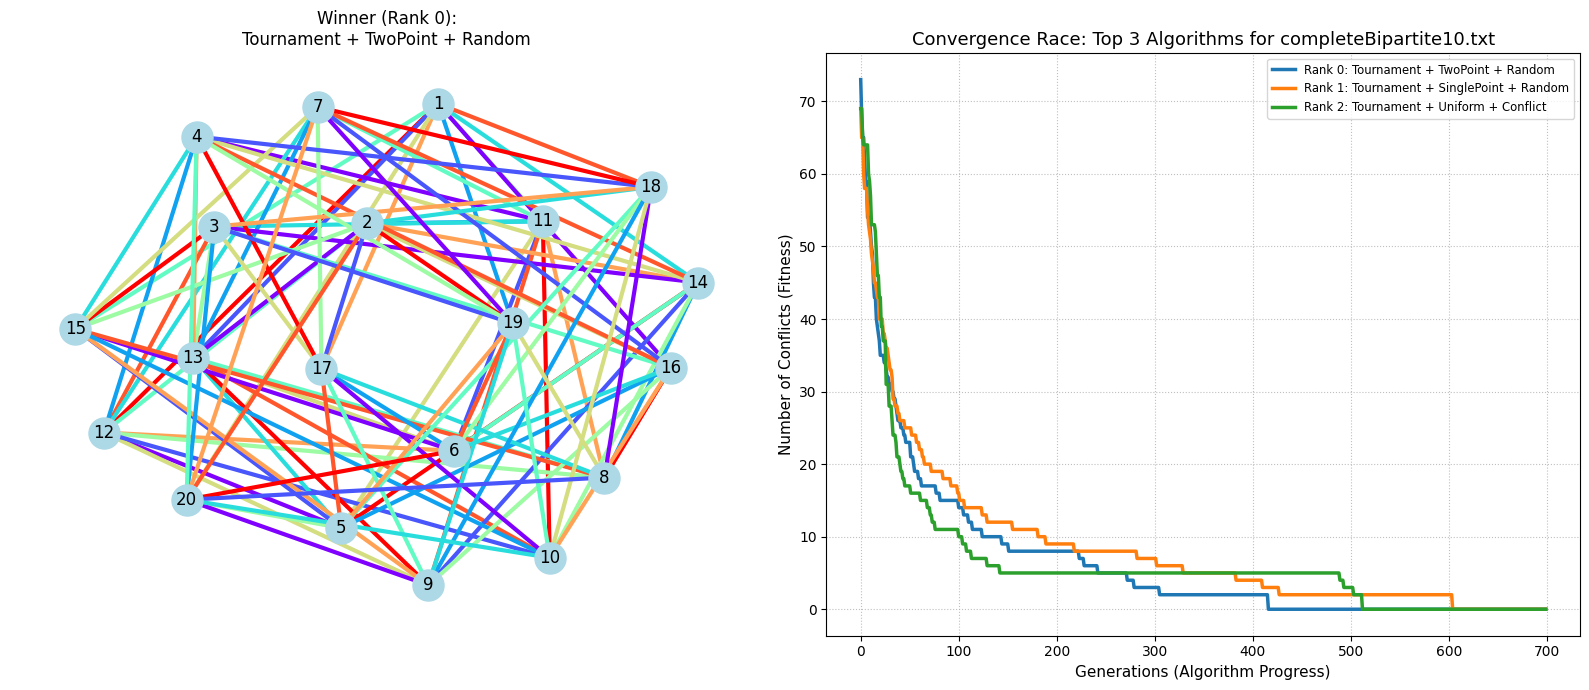

Full table saved to: resultsGA/completeBipartite10.txt


In [108]:

filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/completeBipartite10.txt"
processAndVisualize(filename)

In [35]:
#KASNIJE
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/completeBipartite20.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: completeBipartite20.txt
Stvarni broj čvorova: 40
Stvarni broj ivica: 400
Izračunata Delta: 20


>>> ANALYZING: completeBipartite20.txt
[TYPE]: Bipartite Graph
[THEORY]: Always Class 1 (Expected χ' = Δ = 20)
0 333
1 323
2 314
3 314
4 312
5 312
6 312
7 312
8 302
9 302
10 302
11 302
12 292
13 292
14 292
15 290
16 287
17 287
18 287
19 287
20 276
21 276
22 272
23 272
24 272
25 254
26 249
27 249
28 249
29 243
30 235
31 233
32 233
33 228
34 226
35 225
36 218
37 214
38 211
39 209
40 208
41 203
42 192
43 192
44 190
45 183
46 178
47 176
48 176
49 175
50 172
51 165
52 165
53 162
54 159
55 152
56 152
57 147
58 146
59 145
60 142
61 138
62 138
63 136
64 136
65 134
66 132
67 130
68 126
69 125
70 125
71 125
72 124
73 122
74 120
75 118
76 117
77 116
78 114
79 113
80 112
81 112
82 111
83 110
84 108
85 107
86 105
87 105
88 105
89 102
90 101
91 101
92 100
93 98
94 96
95 96
96 93
97 93
98 91
99 89
100 88
101 87
102 87
103 87
104 86
105 86
106 84
107 83
108 83
109 83
110 81
111 80
112 79
113

KeyboardInterrupt: 


DEBUG ZA FAJL: completeGraph20.txt
Stvarni broj čvorova: 20
Stvarni broj ivica: 190
Izračunata Delta: 19


>>> ANALYZING: completeGraph20.txt
[TYPE]: Complete Graph K(20)
[THEORY]: Class 1 (Expected χ' = Δ = 19)
Top 3 Combinations for completeGraph20.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │        19 │ 20.5566 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ TwoPoint    │ Conflict   │             0 │        19 │ 24.2828 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ SinglePoint │ Random     │             0 │        19 │ 32.1202 │
╘════════╧═════════════

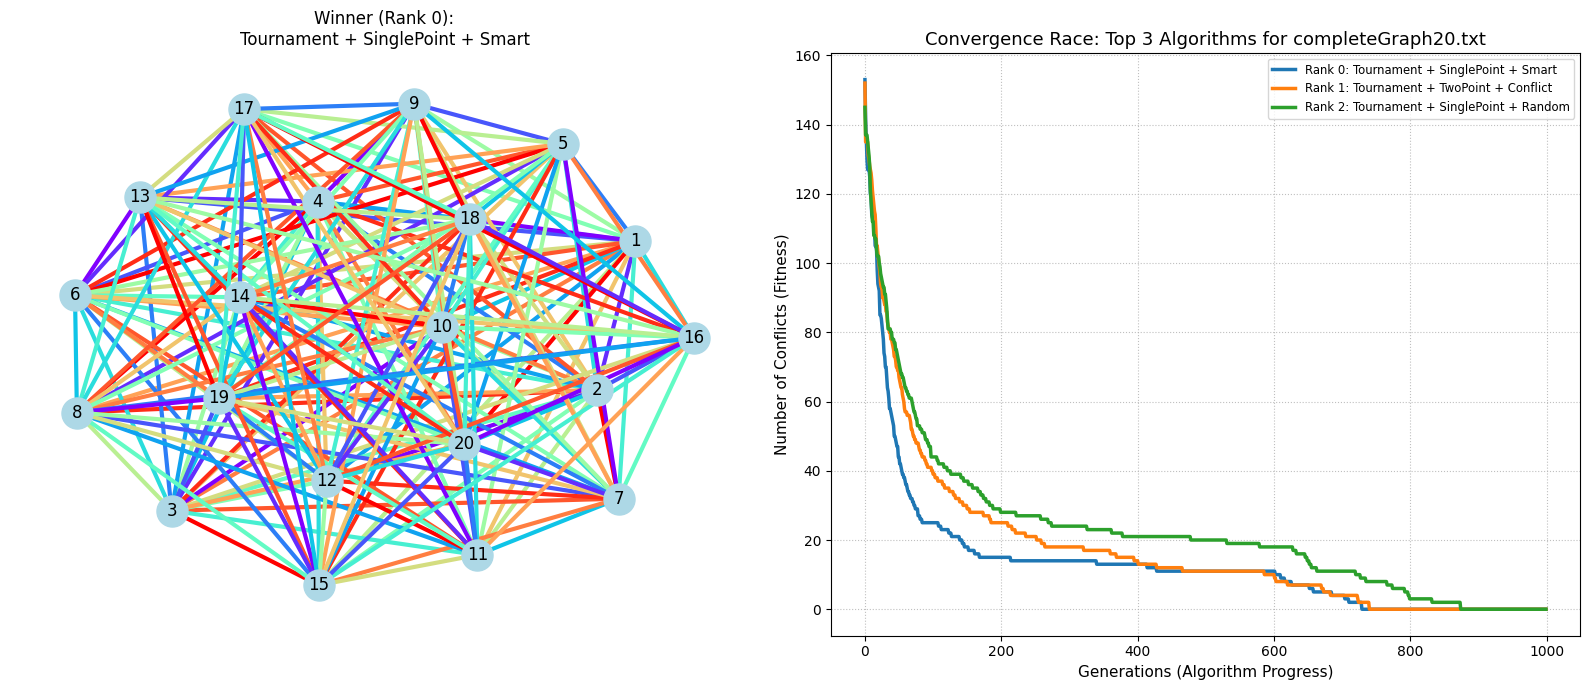

Full table saved to: resultsGA/completeGraph20.txt


In [118]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/completeGraph20.txt"
processAndVisualize(filename)

In [39]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/gcol.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: gcol.txt
Stvarni broj čvorova: 100
Stvarni broj ivica: 2487
Izračunata Delta: 61


>>> ANALYZING: gcol.txt
[TYPE]: Unknown Graph Type


KeyboardInterrupt: 


DEBUG ZA FAJL: graph40_0.8.txt
Stvarni broj čvorova: 40
Stvarni broj ivica: 607
Izračunata Delta: 35


>>> ANALYZING: graph40_0.8.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph40_0.8.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ Uniform     │ Conflict   │             0 │        35 │ 49.8217 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ TwoPoint    │ Conflict   │             0 │        35 │ 82.1803 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ SinglePoint │ Conflict   │             0 │        35 │ 83.3807 │
╘════════╧═════════════╧════════════

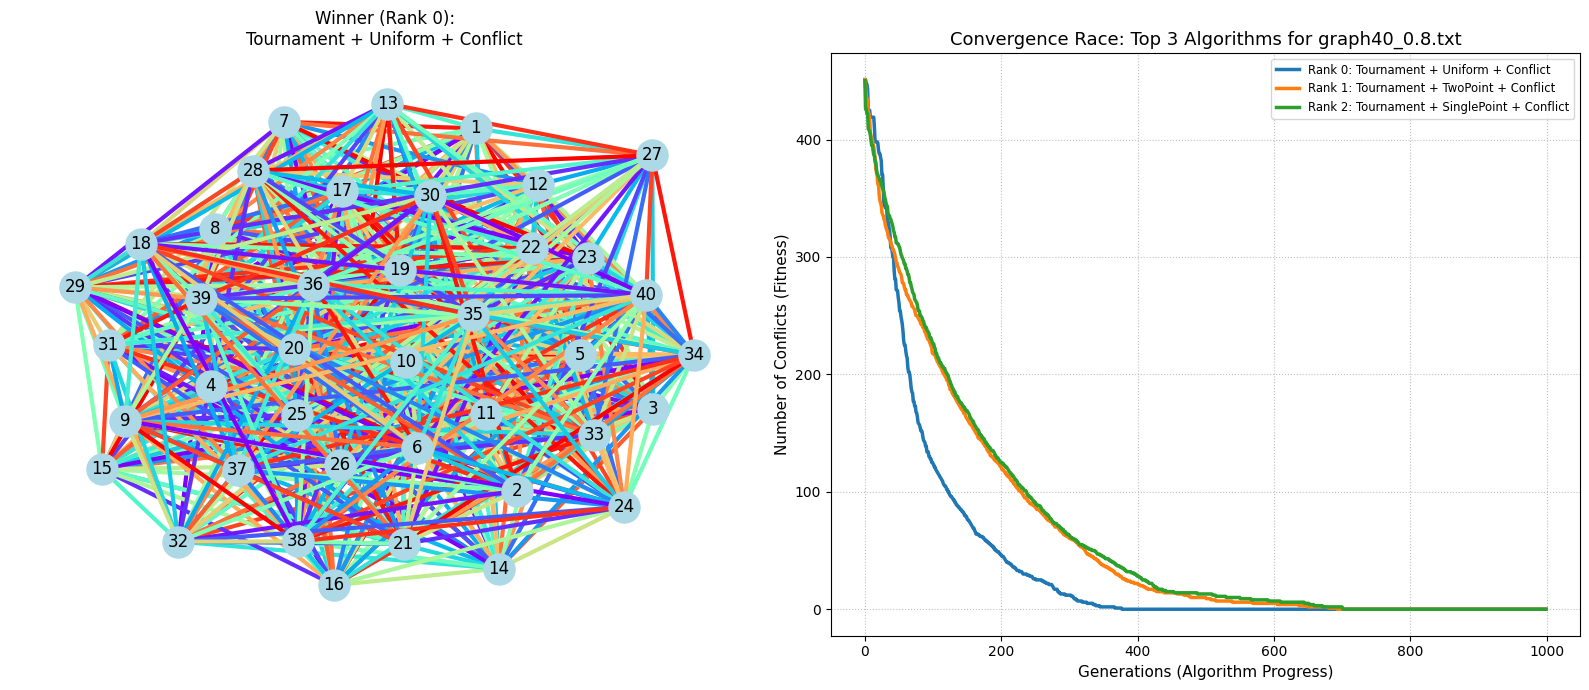

Full table saved to: resultsGA/graph40_0.8.txt


In [136]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/graph40_0.8.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: graph50_0.5.txt
Stvarni broj čvorova: 50
Stvarni broj ivica: 639
Izračunata Delta: 32


>>> ANALYZING: graph50_0.5.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph50_0.5.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ Uniform     │ Conflict   │             0 │        32 │ 36.066  │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ SinglePoint │ Conflict   │             0 │        32 │ 38.1059 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Rank        │ Uniform     │ Conflict   │             0 │        32 │ 45.4057 │
╘════════╧═════════════╧════════════

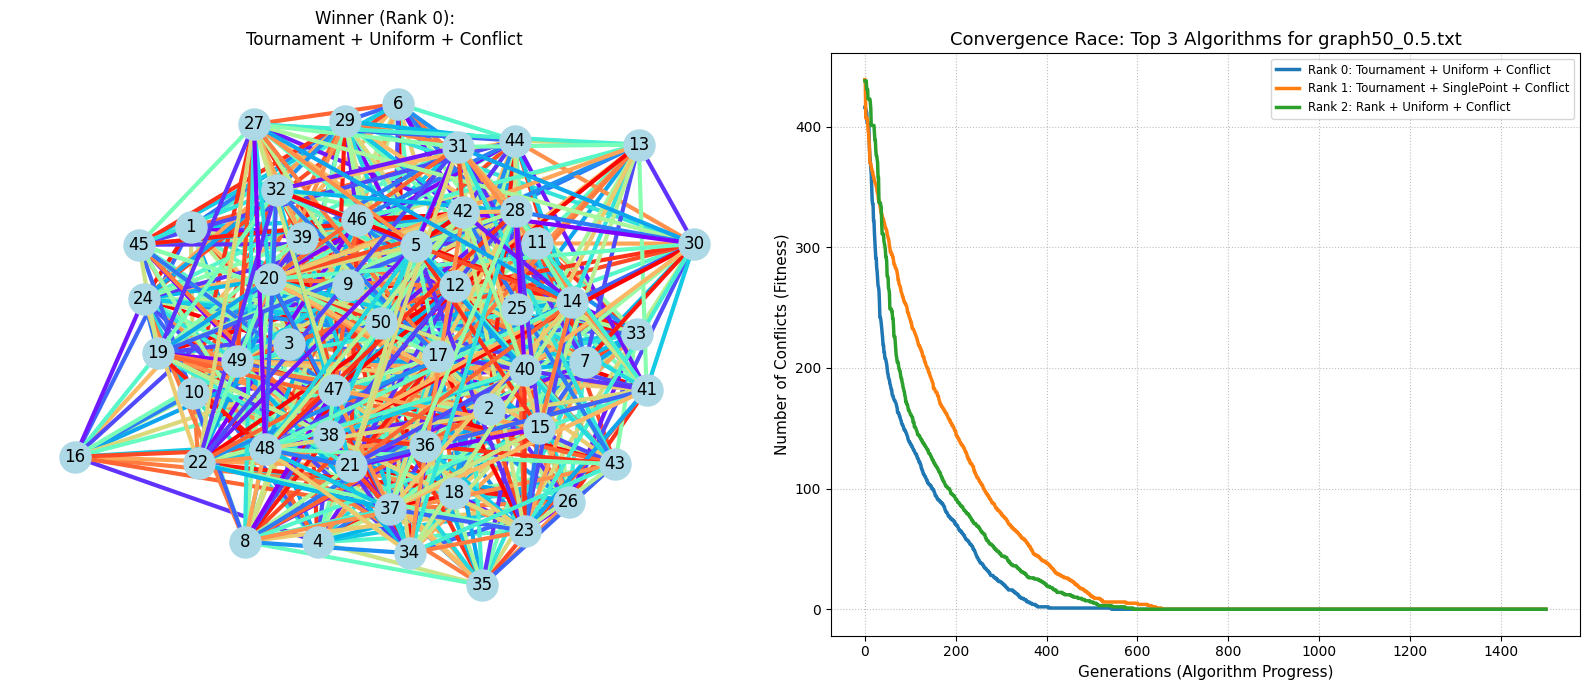

Full table saved to: resultsGA/graph50_0.5.txt


In [148]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/graph50_0.5.txt"
processAndVisualize(filename)

In [ ]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/graph85_0.6.txt"
processAndVisualize(filename)#kasnije


DEBUG ZA FAJL: randomGraph5_50.txt
Stvarni broj čvorova: 50
Stvarni broj ivica: 125
Izračunata Delta: 5


>>> ANALYZING: randomGraph5_50.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for randomGraph5_50.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │         5 │ 11.1717 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ SinglePoint │ Conflict   │             0 │         5 │ 17.1267 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ SinglePoint │ Random     │             2 │         5 │ 30.1896 │
╘════════╧═════════════╧═

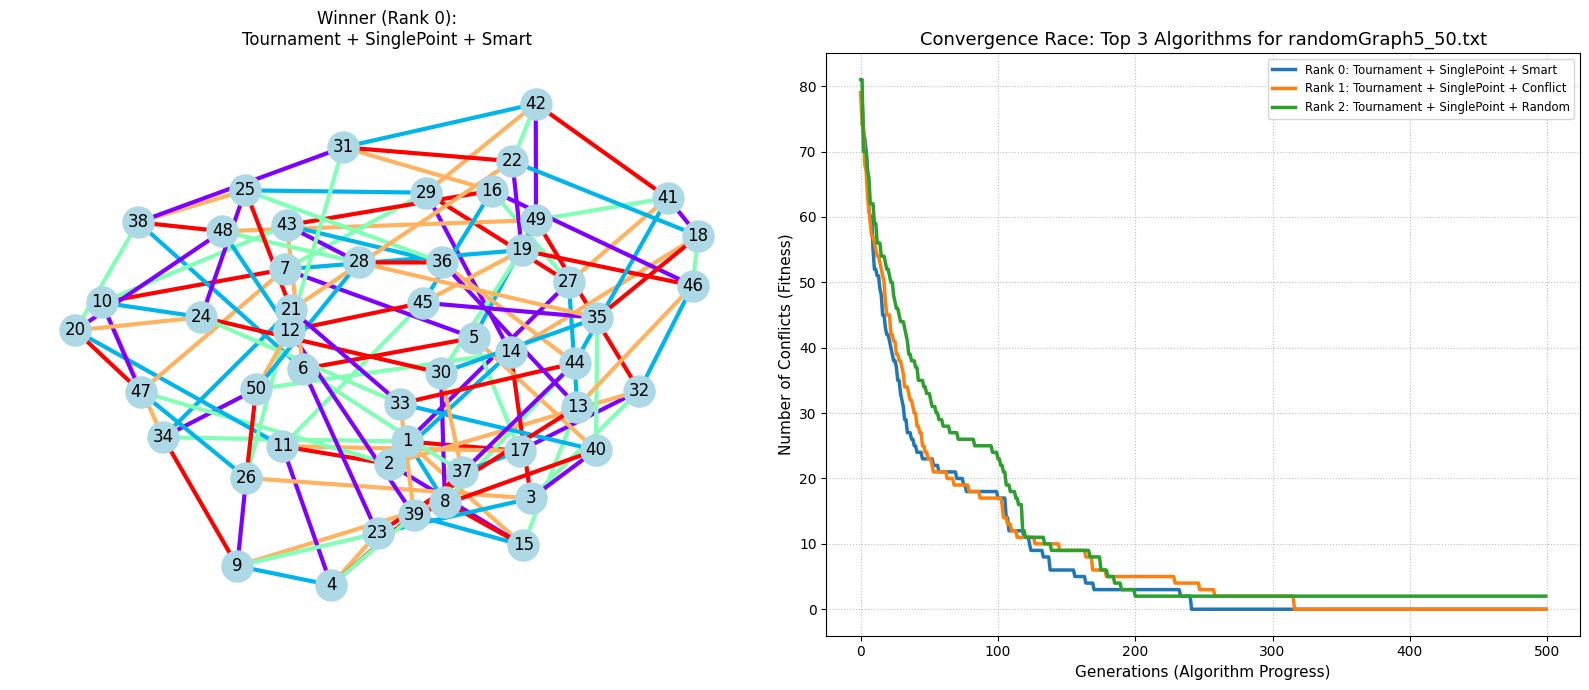

Full table saved to: resultsGA/randomGraph5_50.txt


In [154]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/randomGraph5_50.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: randomGraph6_30.txt
Stvarni broj čvorova: 30
Stvarni broj ivica: 90
Izračunata Delta: 6


>>> ANALYZING: randomGraph6_30.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for randomGraph6_30.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │         6 │ 3.14665 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ SinglePoint │ Conflict   │             0 │         6 │ 4.05247 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Roulette    │ TwoPoint    │ Conflict   │             0 │         6 │ 7.49668 │
╘════════╧═════════════╧══

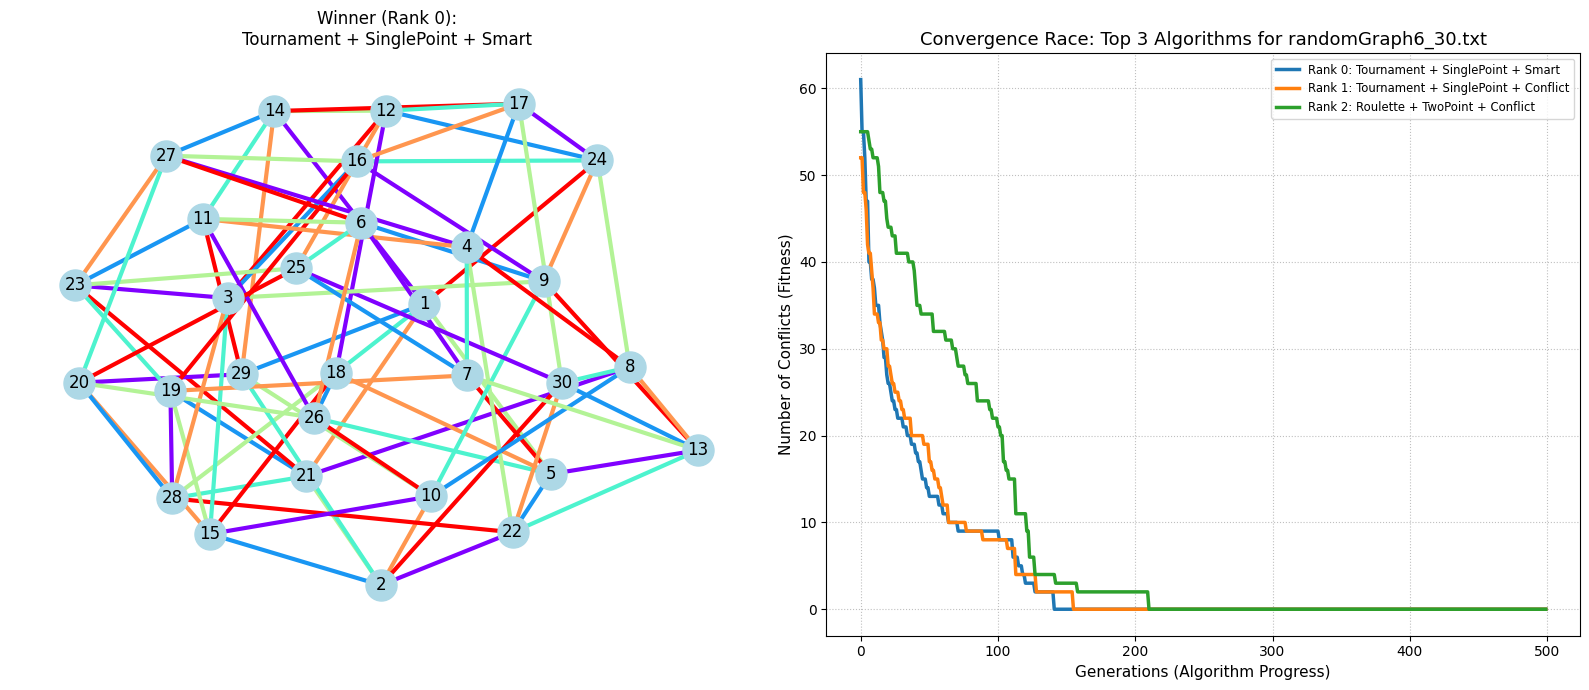

Full table saved to: resultsGA/randomGraph6_30.txt


In [155]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/randomGraph6_30.txt"
processAndVisualize(filename)

In [34]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/randomGraph6_90.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: randomGraph6_90.txt
Stvarni broj čvorova: 90
Stvarni broj ivica: 270
Izračunata Delta: 6


>>> ANALYZING: randomGraph6_90.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
0 184
1 184
2 180
3 180
4 180
5 180
6 180
7 177
8 176
9 164
10 164
11 164
12 164
13 164
14 160
15 159
16 159
17 155
18 153
19 153
20 147
21 143
22 143
23 139
24 139
25 131
26 122
27 122
28 122
29 122
30 122
31 117
32 117
33 115
34 113
35 113
36 108
37 104
38 99
39 99
40 97
41 96
42 91
43 91
44 88
45 84
46 79
47 79
48 75
49 75
50 73
51 70
52 70
53 70
54 64
55 64
56 63
57 62
58 62
59 62
60 60
61 60
62 60
63 59
64 58
65 57
66 57
67 56
68 56
69 55
70 55
71 55
72 55
73 54
74 54
75 54
76 54
77 53
78 53
79 53
80 53
81 53
82 52
83 52
84 51
85 51
86 51
87 50
88 50
89 50
90 50
91 49
92 49
93 48
94 48
95 46
96 46
97 46
98 45
99 45
100 44
101 44
102 44
103 44
104 43
105 43
106 43
107 43
108 43
109 42
110 42
111 42
112 42
113 42
114 42
115 42
116 42
117 42
118 42
119 42
120 41
121 41
122 41


KeyboardInterrupt: 

In [ ]:
#Novo ucitavanje fajla

targetFolders = ['experimentalTests']

for folder in targetFolders:
    #kreiramo putanju za pretragu
    searchPath = os.path.join('tests',folder,"*.txt")
    allFiles = sorted(glob.glob(searchPath))

    if not allFiles:
        print(f"No files found in: tests/{folder}")
        continue

    print(f"\n{'#'*40}\n# ENTERING FOLDER: {folder}\n{'#'*40}")

    for f in allFiles:
        #fileName = os.path.basename(f)
        processAndVisualize(f)